In [1]:

import numpy as np
import pandas as pd
from scipy.sparse import hstack, vstack, csr_matrix
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from typing import Union, List

In [5]:
%%time
def write_to_submission_file(predicted_probs, out_file: str = 'to_submission.csv.zip',
                             target='target', index_label='session_id'):
    df = pd.DataFrame(predicted_probs,
                      index=np.arange(1, len(predicted_probs) + 1),
                      columns=[target])
    df.to_csv(out_file, index_label=index_label, compression="zip")

def convert_types(df: pd.DataFrame) -> pd.DataFrame:
    """ Define all type transformations in a single function """
    sites = [s for s in df.columns if "site" in s]
    df[sites] = df[sites].fillna(0).astype('uint16')
    times = [t for t in df.columns if "time" in t]
    df[times] = df[times].apply(pd.to_datetime)
    if 'target' in df.columns:
        df['target'] = df.target.astype('uint8')
    return df

train_df = pd.read_csv('../../../../data/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/train_sessions.csv.zip')
train_df = convert_types(train_df)
train_df.sort_values(by='time1', inplace=True)

test_df = pd.read_csv('../../../../data/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/test_sessions.csv.zip')
test_df = convert_types(test_df)

sites = [s for s in train_df.columns if 'site' in s]
times = [t for t in train_df.columns if 'time' in t]

# Our target variable
y_train = train_df["target"]

# United dataframe of the initial data
full_df = pd.concat([train_df.drop("target", axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

sites_corpus = full_df[sites].to_string(header=False, index=False).split('\n')

tfv = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
X_train = tfv.fit_transform(sites_corpus[:idx_split])
X_test = tfv.transform(sites_corpus[idx_split:])

X_full = vstack([X_train, X_test]).tocsr()

def get_auc_logit_score(X, y, C=1.0, seed=17, n_splits=10):
    # Split the data into the training and validation sets
    time_split = TimeSeriesSplit(n_splits=n_splits)
    logit = LogisticRegression(C=C, random_state=seed, solver='liblinear')
    cv_scores = cross_val_score(logit, X, y, cv=time_split, scoring='roc_auc', n_jobs=-1)
    return cv_scores.mean()

def get_auc_logit_scores(X, y, C=1.0, seed=17, n_splits=10):
    # Split the data into the training and validation sets
    time_split = TimeSeriesSplit(n_splits=n_splits)
    logit = LogisticRegression(C=C, random_state=seed, solver='liblinear')
    cv_scores = cross_validate(logit, X, y, cv=time_split, scoring='roc_auc',
                               return_train_score=True, n_jobs=-1)
    return cv_scores


def get_auc_rf_score(X, y, seed=17, max_depth=5, n_estimators=10, 
                     n_splits=10, max_features='auto'):
    time_split = TimeSeriesSplit(n_splits=n_splits)
    rf = RandomForestClassifier(random_state=seed, 
                                max_depth=max_depth, 
                                max_features=max_features, 
                                n_estimators=n_estimators)
    cv_scores = cross_val_score(rf, X, y, cv=time_split, scoring='roc_auc', n_jobs=-1)
    return cv_scores.mean()

def get_auc_rf_scores(X, y, seed=17, max_depth=10, n_estimators=10, 
                     n_splits=10, max_features='auto'):
    time_split = TimeSeriesSplit(n_splits=n_splits)
    rf = RandomForestClassifier(random_state=seed, 
                                max_depth=max_depth, 
                                max_features=max_features, 
                                n_estimators=n_estimators)
    cv_scores = cross_validate(rf, X, y, cv=time_split, scoring='roc_auc', 
                               return_train_score=True, n_jobs=-1)
    return cv_scores


def get_features(full_df) -> pd.DataFrame:
    times = [t for t in full_df.columns if 'time' in t]
    feat_df = pd.DataFrame(index=full_df.index)

    feat_df['weekday'] = full_df['time1'].dt.weekday
    for weekday in range(7):
        feat_name = f'weekday_{weekday}'
        feat_df[feat_name] = (full_df['time1'].dt.weekday == weekday).astype(int)
    for hour in range(23):
        feat_name = f'hour_{hour}'
        feat_df[feat_name] = (full_df['time1'].dt.hour == hour).astype(int)

    feat_df['duration'] = (full_df[times].max(axis=1) - full_df[times].min(axis=1)).dt.total_seconds()

    feat_df['hour_sin'] = np.sin(full_df['time1'].dt.hour / 24)
    feat_df['hour_cos'] = np.cos(full_df['time1'].dt.hour / 24)

    feat_df['hour'] = full_df['time1'].dt.hour

    feat_df['morning'] = feat_df['hour'].between(7, 11).astype(int)
    feat_df['noon'] = feat_df['hour'].between(12, 18).astype(int)
    feat_df['evening'] = feat_df['hour'].between(19, 23).astype(int)
    feat_df['night'] = feat_df['hour'].between(0, 6).astype(int)

    deltas = ['delta' + str(i) for i in range(1, 10)]    
    delta_df = (full_df[times] - full_df[times].shift(1, axis=1)) \
        .copy() \
        .drop(columns='time1') \
        .apply(lambda x: x.dt.total_seconds())

    delta_df.columns = deltas
    for delta in deltas:
        feat_df[delta] = delta_df[delta]

    feat_df['delta_avg'] = delta_df.mean(axis=1, skipna=True).fillna(0.0)

    best_hours = ['hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_14', 'hour_16', 'hour_17', 'hour_18',
                  'hour_19', 'hour_20', 'hour_21', 'hour_22']
    best_weekdays = ['weekday_0']
    best_previous = ['morning', 'noon', 'evening']

    return feat_df.fillna(0.0)

# Add the new feature to the sparse matrix
def add_feature(feat: str, X_sparse=None, standardize=True, onehot=False):
    tmp = feat_df[[feat]].values
    if onehot:
        enc = OneHotEncoder(dtype=np.uint8, sparse=False)
        tmp = enc.fit_transform(tmp)
    if standardize:
        tmp = StandardScaler().fit_transform(tmp)
    if X_sparse is not None:
        return hstack([X_sparse, tmp]).tocsr()
    else:
        return csr_matrix(tmp)


def add_multi_feature(feat_list: list, X_sparse=None):
    X_new = X_sparse
    for feat in feat_list:
        X_new = add_feature(feat, X_new)
    return X_new[:idx_split, :], X_new[idx_split:, :]


def test_feature(features: Union[list, str], standardize=True, onehot=False, C=1):
    print(f"Testing:\t{features}")

    if isinstance(features, str):
        features = [features]
    
    X_new = X_full
    for feat in features:
        X_new = add_feature(feat, X_new, onehot=onehot, standardize=standardize)
    X_train_new = X_new[:idx_split, :]
    score = get_auc_logit_score(X_train_new, y_train, C=C)

    print(f"Score:\t\t{score:.4f}\t", end="")

    if score > BASELINE:
        print(f"+++ baseline:\t{BASELINE:.4f}")
    else:
        print(f"--- baseline:\t{BASELINE:.4f}")
    return score


def test_multi_feature(feat_list: list, C=1):
    """
    Deprecated
    """
    print(f"Testing:\t{feat_list}")

    X_new = X_full
    for feat in feat_list:
        X_new = add_feature(feat, X_sparse=X_new)
    X_train_new = X_new[:idx_split, :]
    score = get_auc_logit_score(X_train_new, y_train, C=C)

    print(f"Score:\t\t{score:.4f}\t", end="")
    if score > BASELINE:
        print(f"+++ baseline: {BASELINE:.4f}")
    else:
        print(f"--- baseline: {BASELINE:.4f}")
    return score


def predict_probs(feat_list: list = None, n_splits=10, calc_local = True,
                  estimator=LogisticRegression(C=1, random_state=17, solver='liblinear')):
    X_new = X_full

    if feat_list is not None:
        for feat in feat_list:
            X_new = add_feature(feat, X_sparse=X_new)
    else:
        pass

    X_train_new = X_new[:idx_split, :]
    X_test_new = X_new[idx_split:, :]
    estimator.fit(X_train_new, y_train)

    if calc_local:
        time_split = TimeSeriesSplit(n_splits=n_splits)
        cv_scores = cross_val_score(estimator, X_train_new, y_train, cv=time_split, scoring='roc_auc', n_jobs=-1)
        print(f"Local score: {cv_scores.mean():.4f}")
    return estimator.predict_proba(X_test_new)[:, 1]

def predict_probs_ex(X_train_new, X_test_new, calc_local = True,
                     estimator=LogisticRegression(C=1, random_state=17, solver='liblinear')):
    
    estimator.fit(X_train_new, y_train)
    if calc_local:
        time_split = TimeSeriesSplit(n_splits=n_splits)
        cv_scores = cross_val_score(estimator, X_train_new, y_train, 
                                    cv=time_split, scoring='roc_auc', n_jobs=-1)
        print(f"Local score: {cv_scores.mean():.4f}")

    return estimator.predict_proba(X_test_new)[:, 1]

BASELINE = get_auc_logit_score(X_train, y_train)

feat_df = get_features(full_df)

Wall time: 51.3 s


In [5]:
feat_df.columns

Index(['weekday', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'duration', 'hour_sin', 'hour_cos', 'hour', 'morning',
       'noon', 'evening', 'night', 'delta1', 'delta2', 'delta3', 'delta4',
       'delta5', 'delta6', 'delta7', 'delta8', 'delta9', 'delta_avg'],
      dtype='object')

In [29]:
test_feature(['morning', 'noon', 'evening', 'duration', 'delta_avg', 'weekday'])

Testing:	['morning', 'noon', 'evening', 'duration', 'delta_avg', 'weekday']
Score:		0.9235	+++ baseline:	0.8692


0.9234871654513871

In [6]:
X_train_new, X_test_new = add_multi_feature(['morning', 'noon', 'evening', 
                                 'duration', 'delta_avg', 'weekday'], X_full)
# X_train_new

In [23]:
# Сделаем инициализацию параметров, по которым хотим сделать полный перебор
parameters = {'C': np.logspace(-2, 2, 30)}
logit = LogisticRegression(random_state=17, solver='liblinear')
time_split = TimeSeriesSplit(n_splits=10)
gcv = GridSearchCV(logit, parameters, n_jobs=-1, cv=time_split, verbose=1)
gcv.fit(X_train_new, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=LogisticRegression(random_state=17, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 1.37382380e-02, 1.88739182e-02, 2.59294380e-02,
       3.56224789e-02, 4.89390092e-02, 6.72335754e-02, 9.23670857e-02,
       1.26896100e-01, 1.74332882e-01, 2.39502662e-01, 3.29034456e-01,
       4.52035366e-01, 6.21016942e-01, 8.53167852e-01, 1.17210230e+00,
       1.61026203e+00, 2.21221629e+00, 3.03919538e+00, 4.17531894e+00,
       5.73615251e+00, 7.88046282e+00, 1.08263673e+01, 1.48735211e+01,
       2.04335972e+01, 2.80721620e+01, 3.85662042e+01, 5.29831691e+01,
       7.27895384e+01, 1.00000000e+02])},
             verbose=1)

In [35]:
gcv.best_params_

{'C': 0.06723357536499334}

In [36]:
get_auc_logit_score(X_train_new, y_train, C=gcv.best_params_['C'])

0.9030448747744886

In [37]:
probs = gcv.predict_proba(X_test_new)[:, 1]
write_to_submission_file(probs, 
                         out_file='logit_subm19.csv.zip')

In [38]:
get_auc_logit_score(X_train_new, y_train, C=4.6)

0.9226373145344808

In [41]:
logit = LogisticRegression(C=4.6, random_state=17, solver='liblinear')
logit.fit(X_train_new, y_train)
probs = logit.predict_proba(X_test_new)[:, 1]
write_to_submission_file(probs,
                         out_file='logit_subm20.csv.zip')

In [7]:
%%time
get_auc_logit_scores(X_train_new, y_train, C=4.6)

{'fit_time': array([0.56768775, 1.5770483 , 3.25778556, 3.21892309, 3.99935031,
        4.81857681, 3.73209739, 7.90569973, 7.32327533, 7.56456041]),
 'score_time': array([0.01642871, 0.01795745, 0.02393937, 0.01695561, 0.01695609,
        0.01562309, 0.01196909, 0.01521826, 0.01674914, 0.01582575]),
 'test_score': array([0.8634096 , 0.78669862, 0.93202803, 0.96223785, 0.91339399,
        0.94937796, 0.9562566 , 0.93982634, 0.96078755, 0.96235659]),
 'train_score': array([0.99413486, 0.99043705, 0.98594927, 0.98590643, 0.98593509,
        0.9858232 , 0.98605785, 0.98614976, 0.98663372, 0.98695624])}

In [8]:
%%time
param_grid = np.logspace(-2, 2, 30)
# param_grid = [2, 5]
param_name = 'C'
scores = []
for i, param in enumerate(param_grid):
    print(f"{i + 1} / {len(param_grid)}")
    scores.append(get_auc_logit_scores(X_train_new, y_train, **{param_name: param}))
    
df = pd.DataFrame(scores, index=param_grid)
df.index.name = param_name
df = df.explode(list(df.columns)).reset_index()

1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30
30 / 30


NameError: name 'sns' is not defined

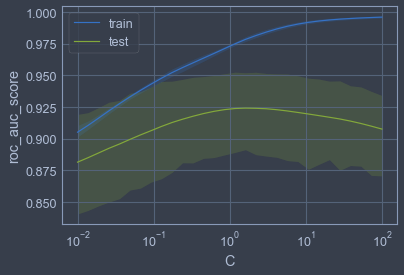

In [10]:
import seaborn as sns
sns.lineplot(y='train_score', x=param_name, data=df, label='train')
sns.lineplot(y='test_score', x=param_name, data=df, label='test')
plt.ylabel('roc_auc_score')
plt.xscale('log')
plt.show()

In [12]:
logit = LogisticRegression(C=1.6, random_state=17, solver='liblinear')
logit.fit(X_train_new, y_train)
print(get_auc_logit_score(X_train_new, y_train, C=1.6))
probs = logit.predict_proba(X_test_new)[:, 1]
write_to_submission_file(probs,
                         out_file='logit_subm21.csv.zip')

0.9241882100054593
